# _MINIBR2050: Thunderdome_

###### May 2020, [@barnabemonnot](https://twitter.com/barnabemonnot)
###### [Robust Incentives Group](https://github.com/ethereum/rig), Ethereum Foundation
###### Built with specs v0.12

---

We really care (and want to check) that honest, protocol-following validators, reap the highest (in-protocol) rewards. We'll get a feel for what this means here by pitting different validator behaviours against each other.

To introduce a bit of terminology, we are doing an _agent-based model_ here. We do not explicitly code a scenario that agents follow, but program simple update and interaction rules, let them unfold for a while and then look at the tape to infer conclusions.

We'll distinguish between _strategies_ and _behaviours_. A validator can do several things: attest, propose, do neither. We'll call _strategies_ instantiations of these particular actions. For instance, a validator may employ the strategy of always attesting correctly, or flipping a coin and half the time attesting correctly, half the time not attesting at all (a pretty dumb strategy if you ask me).

We use the word _behaviour_ to describe the general articulation of these strategies: what to play and _when_. We explored in the [main notebook](https://github.com/ethereum/rig/blob/master/eth2economics/code/beaconrunner2050/br2050.ipynb) the behaviour of the [ASAP validator](https://github.com/ethereum/rig/blob/master/eth2economics/code/beaconrunner2050/ASAPValidator.py), who does something as early as possible according to the specs (at the beginning of the slot for a block proposal, a third of a slot, i.e., 4 seconds in for an attestation).

We'll look at a different behaviour too: the [Prudent validator](https://github.com/ethereum/rig/blob/master/eth2economics/code/beaconrunner2050/PrudentValidator.py). Although validators are expected to propose their block as early as possible, network delays could prevent attesters from receiving the block before a third of the slot has elapsed. ASAP validators would attest anyways, at the risk of voting on the wrong head, before receiving the block for that slot. Prudent validators hedge their bets a bit:

- If more than 4 seconds elapsed into the slot and they have received a block, they attest for that block.
- If more than 8 seconds elapsed into the slot and they still haven't received a block, they attest for the head they know about.

In other words, prudent validators are willing to wait to see if the block will turn up, but won't wait too long either: they need to communicate their attestations in a timely manner after all!

### Rewards under consideration

To see how this impacts the payoff received by ASAP and prudent validators, let's dive into the rewards and penalties schedule for attesters (we won't look at rewards from block proposing here). Note first the following two things:

- Validators receive a bonus for attesting on the correct head. Attesting too early means possibly losing out on this bonus if the head specified in the attestation is incorrect.
- Validators receive a bonus for early inclusion of their attestation in a block. This means that they should attest relatively soon, and cannot wait forever to see if a missing block will turn up.

You can see [here in the specs](https://github.com/ethereum/eth2.0-specs/blob/dev/specs/phase0/beacon-chain.md#get_attestation_deltas) how rewards and penalties are computed at the end of each epoch. Let's unpack it here.

A base reward is computed that depends only on the validator's effective balance (maximum 32 ETH) and the current total active balance (the effective balance of _all_ active validators). Letting $i$ denote our validator,

$$ \texttt{BR[i]} = \texttt{balance[i]} \cdot \frac{\texttt{BRF}}{\sqrt{\texttt{total\_balance}} \cdot \texttt{BRPE}} $$

$\texttt{BRPE}$ stands for _base rewards per epoch_. A validator can be rewarded for

1. Attesting to the correct source, yielding $\texttt{BR[i]}$.
2. Attesting to the correct target, yielding $\texttt{BR[i]}$.
3. Attesting to the correct head, yielding $\texttt{BR[i]}$.
4. Early inclusion, yielding at most $\texttt{BR[i]} \Big( 1 - \frac{1}{\texttt{PRQ}} \Big)$ with $\texttt{PRQ}$ the _proposer reward quotient_.

These four items are why $\texttt{BRPE}$ is set to 4 (at least in phase 0). $\texttt{BRF}$, the _base reward factor_, is a scaling constant currently set at $2^6 = 64$.

For each of the first three items, we scale the base reward by the fraction of the active stake who correctly attested for the item. If $\rho_s$ is the fraction of the stake who attested correctly for the source, then a validator $i$ with a correct source receives $\rho_s \cdot \texttt{BR[i]}$. However, failure to attest or attesting for an incorrect source, target or head incurs the full $\texttt{BR[i]}$ as penalty.

Let's talk about item 4, early inclusion. Attestations may be included at least one slot after the slot they are attesting for, called the _committee slot_. If they are included in the block immediately following their committee slot, they receive the full base reward, minus the _proposer reward_, endowed to the block producer (see table below). If they are included in the block two slots after their committee slot, they receive half. Three blocks later, a third, etc. Attestations must be included at the latest one full epoch after their committee slot. The smallest inclusion reward is thus 1/32 of the base reward (assuming `SLOTS_PER_EPOCH` is equal to 32).

These are the attester rewards in the best of times. Whenever a validator fails to attest for one of the first three items, or attests incorrectly, the penalty is equal to the whole base reward. No discount!

Let's talk about the worst of times, when the chain is not finalising epochs anymore (a situation we explored in a [different notebook](https://github.com/ethereum/rig/blob/master/eth2economics/code/beaconrunner2049/beacon_runner_2049.ipynb)). In this case, we want to "leak" the stake of inactive validators, who are preventing finalisation. A [recent modification](https://github.com/ethereum/eth2.0-specs/pull/1830) makes sure that validators who perform optimally (i.e., attest correctly to all three items and are included in the slot after their committee slot) do not suffer any loss. Meanwhile, validators who are not attesting for the correct target (a key ingredient for finalisation) suffer increasingly painful consequences, as the _finality delay_ (the gap between the current epoch and the last finalised epoch) grows.

This is all synthesised in the following table. "IL" items refer to "Inactivity Leak": the rewards and penalties during these worst of times.

| |  Reward  |  Penalty  | Reward (IL) | Penalty (IL) |
|-|-|-|-|-|
| Correct source? | $\rho_s \cdot \texttt{BR[i]}$ | $\texttt{BR[i]}$ | $\texttt{BR[i]}$ | $\texttt{BR[i]}$ |
| Correct target? | $\rho_t \cdot \texttt{BR[i]}$ | $\texttt{BR[i]}$ | $\texttt{BR[i]}$ | $\texttt{BR[i]}$ |
| Correct head? | $\rho_h \cdot \texttt{BR[i]}$ | $\texttt{BR[i]}$ | $\texttt{BR[i]}$ | $\texttt{BR[i]}$ |
| Correct source _and_ inclusion with delay $d$? | $\Big(1 - \frac{1}{\texttt{PRQ}} \Big) \frac{\texttt{BR[i]}}{d}$ | 0 | $\Big(1 - \frac{1}{\texttt{PRQ}} \Big)\frac{\texttt{BR[i]}}{d}$ | 0 |
| Finality delay $d$ (incurred by everyone) | 0 | 0 | 0 | $\Big( \texttt{BRPE} - \frac{1}{\texttt{PRQ}} \Big) \cdot \texttt{BR[i]}$ |
| Correct target (finality delay = $f$)? | 0 | 0 | 0 | $\texttt{balance[i]} \cdot \frac{f}{\texttt{IPQ}}$ |

Let's take a few examples. We note at the end of the formula whether the result is positive (and the validator makes a profit) or negative (and the validator makes a loss).

- A validator who gets everything correct, included 2 slots after their committee slot, not currently in an inactivity leak reaps:

$$ \Big( \rho_s + \rho_t + \rho_h + \frac{1}{2} (1 - \frac{1}{\texttt{PRQ}}) \Big) \texttt{BR[i]} > 0 $$

- A validator who gets everything correct, included 2 slots after their committee slot, _currently in an inactivity leak_ reaps:

$$ \Big(3 + \frac{1}{2} (1 - \frac{1}{\texttt{PRQ}}) - \texttt{BRPE} + \frac{1}{\texttt{PRQ}} \Big) \texttt{BR[i]} = \Big(-\frac{1}{2} + \frac{1}{2\texttt{PRQ}} \Big) \texttt{BR[i]} < 0 $$

- A validator who gets everything correct _except the target_, included 2 slots after their committee slot, _currently in an inactivity leak_ with finality delay $f$ reaps:

$$ \Big(1 - 1 + 1 + \frac{1}{2} (1 - \frac{1}{\texttt{PRQ}}) - \texttt{BRPE} + \frac{1}{\texttt{PRQ}} \Big) \texttt{BR[i]} - \texttt{balance[i]} \cdot \frac{f}{\texttt{IPQ}} = \Big(-\frac{5}{2} + \frac{1}{2\texttt{PRQ}} \Big) \texttt{BR[i]} - \texttt{balance[i]} \cdot \frac{f}{\texttt{IPQ}} < 0 $$

### Some hypotheses before simulating

In a network with perfect (or close to perfect) latency and honest proposers, we don't expect ASAP and prudent validator earnings to differ significantly. But intuitively, the behaviour of prudent validators appears more _robust_ than that of ASAP validators.

When network delays are high or if we assume block proposers are lazy and don't propagate their blocks in time (or may be prudent themselves, to collect more incoming attestations), prudent validators would reap the "correct head" reward more often. On the other hand, when network delays are really, really high, perhaps proposing ASAP is a better strategy, to make sure that _something_ goes through, even possibly incorrect.

## _"Two nodes enter! One node leaves!"_

Let's pit `PrudentValidator`s against `ASAP`s and observe the result. In this simulation, we let `SLOTS_PER_EPOCH` equal to 4 and simulate a small number of validators. Runs are now random: sometimes the network updates, sometimes it doesn't. We'll set it up later such that on average messages propagate one step further on the network every 4 seconds.

We first load all the necessary packages. The remainder will look a lot like what we have done in the [main notebook](https://github.com/ethereum/rig/blob/master/eth2economics/code/beaconrunner2050/br2050.ipynb), check it out for more background!

In [1]:
%%capture
import specs
import importlib
from eth2spec.config.config_util import prepare_config
from eth2spec.utils.ssz.ssz_impl import hash_tree_root

prepare_config(".", "fast")
importlib.reload(specs)

import network as nt
import brlib

import validatorlib as vlib
from ASAPValidator import *
from PrudentValidator import *

from cadCAD.configuration import Configuration
from cadCAD.configuration.utils import config_sim
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor

from cadCADsupSUP import *

import pandas as pd
from random import sample

from eth2 import gwei_to_eth

We create our _observers_, recording interesting metrics at each simulation step.

In [2]:
current_slot = lambda s: s["network"].validators[0].data.slot

def average_balance_prudent(state):
    validators = state["network"].validators
    validator = validators[0]
    head = specs.get_head(validator.store)
    current_state = validator.store.block_states[head]
    current_epoch = specs.get_current_epoch(current_state)
    prudent_indices = [i for i, v in enumerate(validators) if v.validator_behaviour == "prudent"]
    prudent_balances = [b for i, b in enumerate(current_state.balances) if i in prudent_indices]
    return gwei_to_eth(sum(prudent_balances) / float(len(prudent_indices)))

def average_balance_asap(state):
    validators = state["network"].validators
    validator = validators[0]
    head = specs.get_head(validator.store)
    current_state = validator.store.block_states[head]
    current_epoch = specs.get_current_epoch(current_state)
    asap_indices = [i for i, v in enumerate(validators) if v.validator_behaviour == "asap"]
    asap_balances = [b for i, b in enumerate(current_state.balances) if i in asap_indices]
    return gwei_to_eth(sum(asap_balances) / float(len(asap_indices)))

Let's create a "main" function to run the simulation. The function returns a `pandas` dataframe containing the metrics recorded throughout the run.

In [3]:
def simulate_thunderdome(num_validators, num_epochs, num_run):
    # Half our validators are prudent, the others are ASAPs
    num_prudent = int(num_validators / 2)
    
    # We sample the position on the p2p network of prudent validators randomly
    prudentset = set(sample(range(num_validators), num_prudent))

    # Create a genesis state
    genesis_state = brlib.get_genesis_state(num_validators)

    validators = []

    for i in range(num_validators):
        if i in prudentset:
            new_validator = PrudentValidator(genesis_state.copy(), i)
        else:
            new_validator = ASAPValidator(genesis_state.copy(), i)
        validators.append(new_validator)
    
    brlib.skip_genesis_block(validators)

    # Create the network peers
    set_a = nt.NetworkSet(validators=list(range(0, int(num_validators * 2 / 3.0))))
    set_b = nt.NetworkSet(validators=list(range(int(num_validators / 2.0), num_validators)))

    network = nt.Network(validators = validators, sets=list([set_a, set_b]))
    
    initial_conditions = {
        'network': network
    }

    parameters = {
        "frequency": [1],
        "network_update_rate": [0.25] # The network updates on average at a frequency of 0.25 Hz (i.e., ~ once every 4 seconds)
    }

    psubs = [
        {
            'policies': {
                'action': brlib.attest_policy # step 1
            },
            'variables': {
                'network': brlib.disseminate_attestations # step 2
            }
        },
        {
            'policies': {
                'action': brlib.propose_policy # step 3
            },
            'variables': {
                'network': brlib.disseminate_blocks # step 4
            }
        },
        {
            'policies': {
            },
            'variables': {
                'network': brlib.tick # step 5
            }
        },
    ]
    
    # Determine how many steps the simulation is running for
    num_slots = num_epochs * specs.SLOTS_PER_EPOCH
    steps = num_slots * specs.SECONDS_PER_SLOT * parameters["frequency"][0]

    simulation_parameters = {
        'T': range(steps),
        'N': 1,
        'M': parameters
    }

    print("will simulate", num_epochs, "epochs (", num_slots, "slots ) at frequency", vlib.frequency, "moves/second")
    print("total", steps, "simulation steps")

    # Add our observers to the simulation
    observers = {
        "current_slot": current_slot,
        "average_balance_prudent": average_balance_prudent,
        "average_balance_asap": average_balance_asap,
    }

    observed_ic = get_observed_initial_conditions(initial_conditions, observers)
    observed_psubs = get_observed_psubs(psubs, observers)
    
    # Final simulation parameters and execution
    configs = []
    for sim_param in config_sim(simulation_parameters):  
        config = Configuration(sim_param,
                               initial_state=observed_ic, 
                               partial_state_update_blocks=observed_psubs)
        configs.append(config)

    exec_mode = ExecutionMode()
    single_proc_ctx = ExecutionContext(context=exec_mode.single_proc)
    run = Executor(exec_context=single_proc_ctx, configs=configs)
    raw_result, tensor_field = run.execute()
    
    return pd.DataFrame(raw_result).assign(run = num_run)

To do a fair amount of runs simulating a good number of epochs, we set a low number of validators (12). Since we are more interested in comparing individual rewards between ASAP and prudent validators rather than macro-properties or even scalability of the chain, this is not a bad thing to do (and it speeds things up quite a bit).

In [4]:
%%capture

num_validators = 12
num_epochs = 20
num_run = 40

df = pd.concat([simulate_thunderdome(num_validators, num_epochs, run) for run in range(num_run)])

We have 4 slots per epoch, 20 epochs, we can read the average balances at slot 81, after the 20th epoch rewards and penalties were computed.

In [5]:
df[df.current_slot == 81][['average_balance_prudent', 'average_balance_asap']].describe()

,average_balance_prudent,average_balance_asap
count,40.000000,40.000000
mean,32.058037,32.055499
std,0.001174,0.001801
min,32.055722,32.051476
25%,32.057224,32.054408
50%,32.057974,32.055239
75%,32.059091,32.057217
max,32.060157,32.058419


It doesn't seem like a big difference, yet on average prudent validators have higher earnings than ASAPs! Looking at the standard error, the means appear rather significantly different (we could test it more precisely). Let's chart the ensemble mean over the 40 runs too:

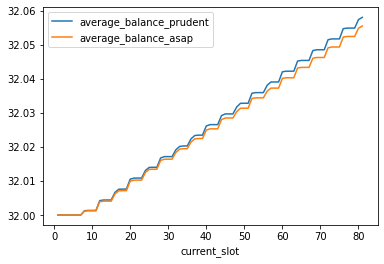

In [14]:
df.groupby(["current_slot"]).mean().reset_index().plot("current_slot", ["average_balance_prudent", "average_balance_asap"])

Prudent validators definitely overtake ASAP validators. 20 epochs is not that long: at 12 seconds per slot, 32 slots per epoch (hence 6.4 minutes per epoch), 20 epochs are merely about 2 hours. Over time these differences accumulate.